In [2]:
using Pkg; Pkg.activate("/Users/jj/JuliaProjects/LaserLab/")

  Activating project at `~/JuliaProjects/LaserLab`


In [3]:
using PlutoUI
using Statistics
using StatsBase
using Plots
using Unitful
using Peaks
using Glob
using FFTW
using DSP
using DataFrames
using CSV
using LsqFit

In [4]:
using Markdown
using PlutoUI

In [5]:
import Unitful:
    nm, μm, mm, cm, m, km,
    mg, g, kg,
    ps, ns, μs, ms, s, minute, hr, d, yr, Hz, kHz, MHz, GHz,
    eV,
    μJ, mJ, J,
	μW, mW, W,
    A, N, mol, mmol, V, L, M

In [6]:
function ingredients(path::String)
	# this is from the Julia source code (evalfile in base/loading.jl)
	# but with the modification that it returns the module instead of the last object
	name = Symbol(basename(path))
	m = Module(name)
	Core.eval(m,
        Expr(:toplevel,
             :(eval(x) = $(Expr(:core, :eval))($name, x)),
             :(include(x) = $(Expr(:top, :include))($name, x)),
             :(include(mapexpr::Function, x) = $(Expr(:top, :include))(mapexpr, $name, x)),
             :(include($path))))
	m
end

ingredients (generic function with 1 method)

In [7]:
lfi = ingredients("../src/LaserLab.jl")

┌ Warning: Replacing docs for `Main.LaserLab.jl.LaserLab.read_waveform :: Tuple{String, String}` in module `Main.LaserLab.jl.LaserLab`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.LaserLab.jl.LaserLab.read_waveform :: Tuple{Vector{String}, Integer}` in module `Main.LaserLab.jl.LaserLab`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.LaserLab.jl.LaserLab.proms :: Tuple{Vector{String}, Integer, Integer}` in module `Main.LaserLab.jl.LaserLab`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.LaserLab.jl.LaserLab.select_peaks :: Tuple{Vector{String}, Integer, Integer}` in module `Main.LaserLab.jl.LaserLab`
└ @ Base.Docs docs/Docs.jl:240


Main.LaserLab.jl

In [8]:
md"""
# Functions
"""

# Functions


In [9]:
function get_files(pmtdir, expdir, datadir, dfiles ="*.trc")
    xpath = joinpath(pmtdir,expdir, datadir)
    Glob.glob(dfiles, xpath)
end

get_files (generic function with 2 methods)

In [10]:
function get_wvfm(pmtdir, file)
    zpath = joinpath(pmtdir,file)
    zio = open(zpath, "r")
    WAVEDESC = lfi.LaserLab.wavedesc(zio)
    address = lfi.LaserLab.scope_rawdata(zio, WAVEDESC)
    lfi.LaserLab.xydata(zio, address)
end

get_wvfm (generic function with 1 method)

In [11]:
function closest_element(xarray::Vector{Float64}, x0::Float64)
    mindx = typemax(Float64)
    for x in xarray
        dx = x0 - x
        if dx < mindx && dx > 0
            mindx = dx
        end
    end
    mindx
end 

closest_element (generic function with 1 method)

In [12]:
function subtract_laser(tv::Vector{Float64}, ltus::Float64)
	tv - ltus * floor.(tv/ltus)
end

subtract_laser (generic function with 1 method)

# Analysis

In [13]:
pmtdir  ="/Users/jj/JuliaProjects/LaserLab/labdata/PMT2"
odir  = "/Users/jj/JuliaProjects/LaserLab/data/PMT"
dfiles ="*.trc"
dplots ="*.png"

md"""
### Data:

- imput dir  = $pmtdir
- output dir = $odir
"""


### Data:

  * imput dir  = /Users/jj/JuliaProjects/LaserLab/labdata/PMT2
  * output dir = /Users/jj/JuliaProjects/LaserLab/data/PMT


In [14]:
tl = 1.0μs
lf = uconvert(MHz, 1.0/tl)
ffmhz = 300.0
md"""
### Experiment conditions:

- laser repetition time = $tl
- laser frequency = $lf
- Filter max frequency (MHz) = $ffmhz
"""

### Experiment conditions:

  * laser repetition time = 1.0 μs
  * laser frequency = 1.0 MHz
  * Filter max frequency (MHz) = 300.0


### Get list of directories with PMT data

In [15]:
readdir(pmtdir)
dirs = lfi.LaserLab.getbolddirs(pmtdir)

8-element Vector{SubString{String}}:
 "ANN_205_Ba"
 "ANN_205_Free"
 "BOLD_062_RuSi"
 "BOLD_068_B1"
 "BOLD_068_C1"
 "BOLD_78_C2_Ba"
 "BOLD_ANN205_bottle"
 "Bold_068_A1"

### Select directory to be studied

In [16]:
sexp = "BOLD_78_C2_Ba"

"BOLD_78_C2_Ba"

In [17]:
csvdir, pngdir = lfi.LaserLab.output_dirs!(odir, sexp)
md"""

CSV and PNG dirs:

- csv dir = $csvdir
- png dir = $pngdir
"""

CSV and PNG dirs:

  * csv dir = /Users/jj/JuliaProjects/LaserLab/data/PMT/BOLD_78_C2_Ba/csv
  * png dir = /Users/jj/JuliaProjects/LaserLab/data/PMT/BOLD_78_C2_Ba/png


### Get data directories and laser directory

In [18]:
path = joinpath(pmtdir,sexp)
readdir(path)
dirs = lfi.LaserLab.getbolddirs(path)
println(dirs)

SubString{String}["Filter7", "Laser"]


In [19]:
fltdir = dirs[1]
lsrdir = dirs[2]
md"""
- data dir = $fltdir
- laser dir = $lsrdir
"""

  * data dir = Filter7
  * laser dir = Laser


### Get list of data and laser files

In [20]:
xfiles = get_files(pmtdir, sexp, fltdir)
lfiles = get_files(pmtdir, sexp, lsrdir)
nxfiles = length(xfiles)
nlfiles = length(lfiles)
md"""
- number of data files = $nxfiles
- number of laser files = $nlfiles
"""

  * number of data files = 1011
  * number of laser files = 2



### Select files to read

In [21]:
xnf =1
lnf = 2
md"""
- data file to read = $xnf
- laser file to read = $lnf
"""

  * data file to read = 1
  * laser file to read = 2


### get data waveform for event

In [22]:
wvfm = get_wvfm(pmtdir,xfiles[xnf])
tw = round(wvfm.time[end] - wvfm.time[1], sigdigits=2) * μs
sr = lfi.LaserLab.sampling_rate(wvfm, tw)
sp = lfi.LaserLab.sampling_period(wvfm, tw)
stats = lfi.LaserLab.wstats(wvfm; nsigma=3.0)
md"""
- Waveform length = $(tw) μs
- sampling rate   = $(round(sr/GHz, sigdigits=2)) GHz
- sampling period = $(round(sp/ns, sigdigits=4)) ns
- baseline at     => $(round(stats.mean, sigdigits=3)) mV
- baseline std    => $(round(stats.std, sigdigits=3)) mV
	"""

  * Waveform length = 200.0 μs μs
  * sampling rate   = 2.5 GHz
  * sampling period = 0.4 ns
  * baseline at     => -0.0837 mV
  * baseline std    => 0.388 mV




In [23]:
ffhz = ffmhz*1e+6    # in Hz
fwvfm = lfi.LaserLab.filter_signal_lp(wvfm, tw; filtertype= "Butterworth", flhz=ffhz)
fstats = lfi.LaserLab.wstats(fwvfm; nsigma=3.0)

md"""

Filtered signal:


- baseline at     => $(round(fstats.mean, sigdigits=3)) mV
- baseline std    => $(round(fstats.std, sigdigits=3)) mV
- threhold (+) at => $(round(fstats.thrp, sigdigits=3)) mV
- threhold (-) at => $(round(fstats.thrn, sigdigits=3)) mV
	"""

Filtered signal:

  * baseline at     => -0.0837 mV
  * baseline std    => 0.211 mV
  * threhold (+) at => 0.549 mV
  * threhold (-) at => -0.716 mV




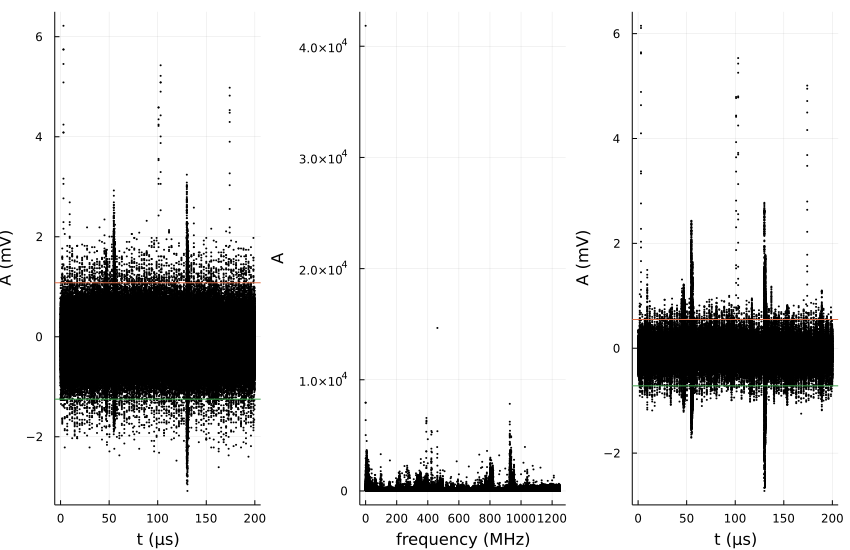

In [24]:
pwvfm = lfi.LaserLab.plot_waveform(wvfm, stats; sct=true, window=false, ws=1, we=50000, trace=false)
pfft = lfi.LaserLab.plot_fft(wvfm,tw; sct=true, window=false, ws=1, we=50000)
pfwvfm = lfi.LaserLab.plot_waveform(fwvfm, fstats; sct=true, window=false, ws=1, we=50000, trace=false)
plot(size=(850,550), pwvfm, pfft, pfwvfm, layout=(1,3), titlefontsize=8)

## Filter signal

### Prominence cut

In [25]:
promsel = 2.5

2.5

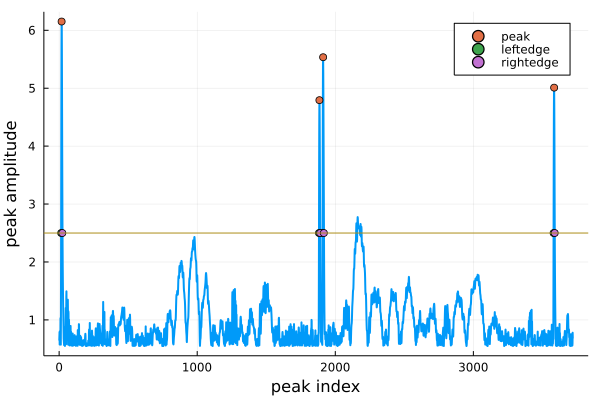

In [26]:
rfpeaks = lfi.LaserLab.select_filtered_peaks(fwvfm, fstats.thrp; 
                                              promsel=promsel, wsel=0.0)

if rfpeaks != Nothing
    wvflt, fpeaks = rfpeaks
    lfi.LaserLab.plot_filtered_peaks(wvflt, fpeaks)
end

In [27]:
fpeaks.xs

4-element Vector{Float64}:
   2.9751999548743857
 100.8699984552941
 103.01679885318937
 174.11320749974314

### Get data waveform for laser

In [28]:
lwvfm = get_wvfm(pmtdir,lfiles[lnf]) 
lstats = lfi.LaserLab.wstats(lwvfm; nsigma=3.0)
md"""
- baseline at     => $(round(lstats.mean, sigdigits=3)) mV
- baseline std    => $(round(lstats.std, sigdigits=3)) mV
"""

  * baseline at     => -12.2 mV
  * baseline std    => 35.6 mV


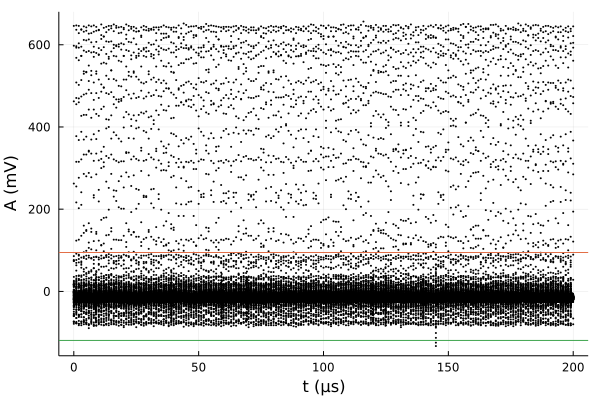

In [29]:
plwvfm = lfi.LaserLab.plot_waveform(lwvfm, lstats; sct=true, window=false, ws=1, we=50000, trace=false)

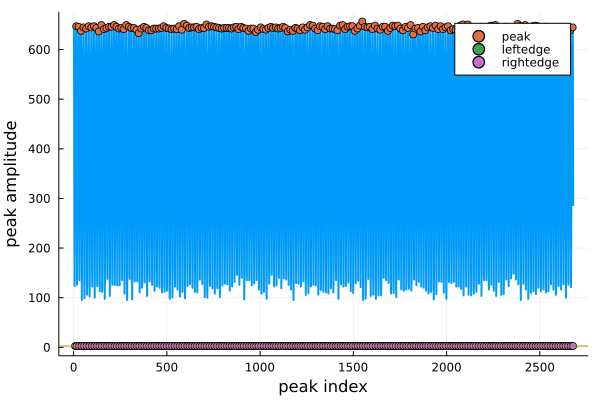

In [30]:
rflsr = lfi.LaserLab.select_filtered_peaks(lwvfm, lstats.thrp; 
                                              promsel=promsel, wsel=0.0)

if rflsr != Nothing
    lwvflt, lpeaks = rflsr
    lfi.LaserLab.plot_filtered_peaks(lwvflt, lpeaks)
end

In [31]:
lpeaks.xs[1:10]

10-element Vector{Float64}:
 1.0000000614518445
 1.9999999452402495
 3.00000005640233
 3.9995999898956303
 4.999599873684035
 5.999600212219791
 6.999600096008196
 8.000000157465381
 9.000000496001137
 9.999999925042191

In [32]:
fpeaks.xs

4-element Vector{Float64}:
   2.9751999548743857
 100.8699984552941
 103.01679885318937
 174.11320749974314

In [33]:
[closest_element(lpeaks.xs, x0) for x0 in fpeaks.xs]

4-element Vector{Float64}:
 0.9752000096341362
 0.8711940608918667
 0.018400896806269884
 0.11520751286298037

In [34]:
tsl = subtract_laser(fpeaks.xs, tl/1.0μs)

4-element Vector{Float64}:
 0.9751999548743857
 0.8699984552940947
 0.016798853189371243
 0.11320749974314026

200.0 μs

In [50]:
function get_times(pmtdir, xfiles, lfile; imax=100, ffmhz=300, promsel=2.5, tl=1.0μs)
    
    lwvfm  = get_wvfm(pmtdir,lfiles[lnf]) 
    tw     = round(lwvfm.time[end] - lwvfm.time[1], sigdigits=2) * μs
    lstats = lfi.LaserLab.wstats(lwvfm; nsigma=3.0)
    rflsr  = lfi.LaserLab.select_filtered_peaks(lwvfm, lstats.thrp; 
                                               promsel=promsel, wsel=0.0)

    if rflsr != Nothing
        _, lpeaks = rflsr
    end
    
    T0 = Float64[]
    T1 = Float64[]
    
    for xnf in 1:min(imax, length(xfiles))
        wvfm = get_wvfm(pmtdir,xfiles[xnf])
        ffhz = ffmhz*1e+6    # in Hz
        fwvfm = lfi.LaserLab.filter_signal_lp(wvfm, tw; filtertype= "Butterworth", flhz=ffhz)
        fstats = lfi.LaserLab.wstats(fwvfm; nsigma=3.0)
        rfpeaks = lfi.LaserLab.select_filtered_peaks(fwvfm, fstats.thrp; 
                                              promsel=promsel, wsel=0.0)

        if rfpeaks != Nothing
            _, fpeaks = rfpeaks
        end
        append!(T0, subtract_laser(fpeaks.xs, tl/1.0μs))
        append!(T1, [closest_element(lpeaks.xs, x0) for x0 in fpeaks.xs])
    end
    T0,T1
end


get_times (generic function with 6 methods)

In [51]:
T0,T1 = get_times(pmtdir, xfiles, lfiles[lnf]; imax=100, ffmhz=300, promsel=2.5, tl=1.0μs)

([0.9751999548743857, 0.8699984552940947, 0.016798853189371243, 0.11320749974314026, 0.30800365588130774, 0.1691958217552667, 0.9627985551624221, 0.4368001211105508, 0.014804397024832383, 0.1667998286566359  …  0.7212031011140709, 0.5187976372099286, 0.814000901779778, 0.7328018213293319, 0.015605096020436804, 0.3448086783892279, 0.8208045184283179, 0.3108042224912566, 0.8803963142118221, 0.01440964105043463], [0.9752000096341362, 0.8711940608918667, 0.018400896806269884, 0.11520751286298037, 0.30880619306117296, 0.17038837540894747, 0.9635987225919962, 0.4375979187898338, 0.016400008462369442, 0.1683947630226612  …  0.7235939847305417, 0.5211913958191872, 0.814401573734358, 0.7347989594563842, 0.01760781742632389, 0.3468012437224388, 0.8220013114623725, 0.3120003384537995, 0.8823990356177092, 0.016400008462369442])

In [52]:
T0 .- T1

513-element Vector{Float64}:
 -5.475975051183468e-8
 -0.001195605597771987
 -0.0016020436168986407
 -0.002000013119840105
 -0.0008025371798652259
 -0.0011925536536807613
 -0.0008001674295741168
 -0.0007977976792830077
 -0.001595611437537059
 -0.0015949343660253135
 -0.0016011947163718787
 -0.0020010338493960944
 -0.0003980495830404607
  ⋮
 -0.0023922377594942645
 -0.001991044483446558
 -0.0023908836164707736
 -0.0023937586092586116
 -0.0004006719545799342
 -0.001997138127052267
 -0.002002721405887087
 -0.001992565333210905
 -0.0011967930340546218
 -0.0011961159625428763
 -0.002002721405887087
 -0.0019903674119348125

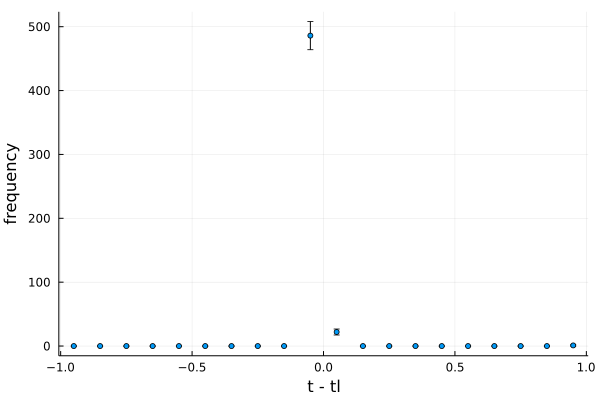

In [53]:
htsl = lfi.LaserLab.h1d(T0 .- T1, 20, -1.0, 1.0)
ptsl = lfi.LaserLab.plot_h1d(htsl, "t - tl")